<a href="https://colab.research.google.com/github/ProfessorPatrickSlatraigh/CST3512/blob/main/CST3512_WM_ch10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data Aggregation and Group Operations    

*from Wes McKinney's Python for Data Analysis, 2nd Edition*   


Categorizing a dataset and applying a function to each group, whether an aggregation or transformation, can be a critical component of a data analysis workflow. After loading, merging, and preparing a dataset, you may need to compute group statistics or possibly pivot tables for reporting or visualization purposes. pandas provides a versatile groupby interface, enabling you to slice, dice, and summarize datasets in a natural way.

One reason for the popularity of relational databases and SQL (which stands for “structured query language”) is the ease with which data can be joined, filtered, transformed, and aggregated. However, query languages like SQL impose certain limitations on the kinds of group operations that can be performed. As you will see, with the expressiveness of Python and pandas, we can perform quite complex group operations by expressing them as custom Python functions that manipulate the data associated with each group. In this chapter, you will learn how to:

* Split a pandas object into pieces using one or more keys (in the form of functions, arrays, or DataFrame column names)    

* Calculate group summary statistics, like count, mean, or standard deviation, or a user-defined function    

* Apply within-group transformations or other manipulations, like normalization, linear regression, rank, or subset selection    

* Compute pivot tables and cross-tabulations    

* Perform quantile analysis and other statistical group analyses    



---



##Housekeeping   

In [ ]:
import numpy as np
import pandas as pd
PREVIOUS_MAX_ROWS = pd.options.display.max_rows
pd.options.display.max_rows = 20
np.random.seed(12345)
import matplotlib.pyplot as plt
plt.rc('figure', figsize=(10, 6))
np.set_printoptions(precision=4, suppress=True)

**Additional Housekeeping**     

*The following modules are used later in the notebook and can be loaded now, if you like.*     

* import **statsmodels.api** as sm     

* from **io** import **StringIO**     


In [ ]:
# execute the following imports now or later when they are used in the notebook    
import statsmodels.api as sm 
from io import StringIO    




---



##10.1 How to Think About Group Operations    

Hadley Wickham, an author of many popular packages for the R programming language, coined the term split-apply-combine for describing group operations. In the first stage of the process, data contained in a pandas object, whether a Series, DataFrame, or otherwise, is split into groups based on one or more keys that you provide. The splitting is performed on a particular axis of an object. For example, a DataFrame can be grouped on its rows (axis=0) or its columns (axis=1). Once this is done, a function is applied to each group, producing a new value. Finally, the results of all those function applications are combined into a result object. The form of the resulting object will usually depend on what’s being done to the data. See Figure 10.1 for a mockup of a simple group aggregation.    

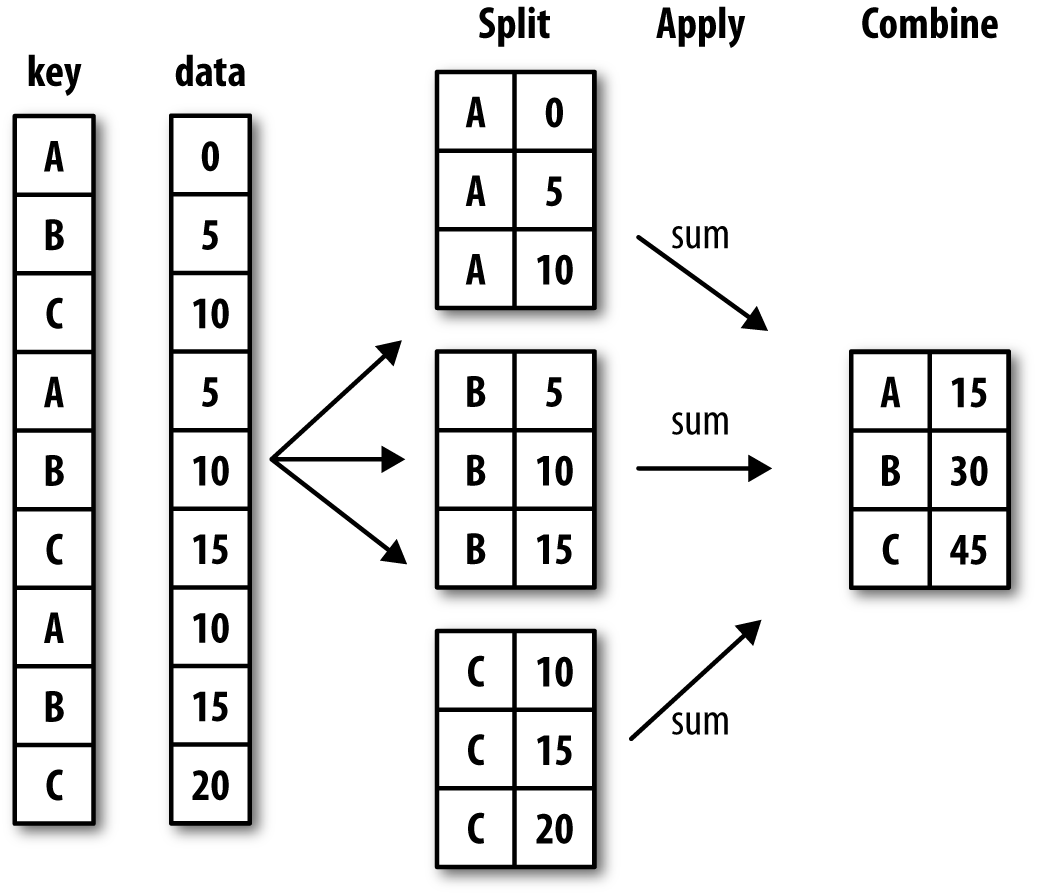

Each grouping key can take many forms, and the keys do not have to be all of the same type:    

* A list or array of values that is the same length as the axis being grouped

* A value indicating a column name in a DataFrame

* A dict or Series giving a correspondence between the values on the axis being grouped and the group names

* A function to be invoked on the axis index or the individual labels in the index

*Note that the latter three methods are shortcuts for producing an array of values to be used to split up the object. Don’t worry if this all seems abstract. Throughout this chapter, I will give many examples of all these methods.*     

To get started, here is a small tabular dataset as a DataFrame:

## GroupBy Mechanics

In [ ]:
df = pd.DataFrame({'key1' : ['a', 'a', 'b', 'b', 'a'],
                   'key2' : ['one', 'two', 'one', 'two', 'one'],
                   'data1' : np.random.randn(5),
                   'data2' : np.random.randn(5)})
df

###What does `df['data1']` return? 

In [ ]:
print(type(df['data1']))

In [ ]:
print("The values in the Series returned by df['data1'] are: ")
for series_value in df['data1'] :
    print(series_value)

Suppose you wanted to compute the mean of the data1 column using the labels from key1. There are a number of ways to do this. One is to access data1 and call groupby with the column (a Series) at `key1`:

Using the Series returned and invoking `.groupby()` on another column from the `df` dataframe.    

In [ ]:
grouped = df['data1'].groupby(df['key1'])
grouped

###What is a `groupby` Series?    

[from pandas.pydata.org](https://pandas.pydata.org/docs/reference/api/pandas.Series.groupby.html):    

A groupby operation involves some combination of splitting the object, applying a function, and combining the results. This can be used to group large amounts of data and compute operations on these groups.

In [ ]:
print('The length of the variable grouped is: ', len(grouped), '\n') 

i = 0
for grouped_item in grouped:
    print('Row', i, 'value ->', grouped_item, '\n')
    i += 1

What if we assign the values of the `grouped` groupby Series into a tuple?

In [ ]:
i = 0
for grouped_item in grouped:
    (key, value) = grouped_item
    print('\n\nFor row', i)
    print('\t\tkey is ', key)
    print('\t\tvalue is |', value, '|')
    i += 1

This `grouped` variable is now a special "GroupBy" object. It has not actually computed anything yet except for some intermediate data about the group key `df['key1']`. The idea is that this object has all of the information needed to then apply some operation to each of the groups. For example, to compute group means we can call the GroupBy’s `.mean()` method:

In [ ]:
grouped.mean()

Later, I'll explain more about what happens when you call `.mean()`. The important thing here is that the data (a Series) has been aggregated by splitting the data on the group key, producing a new Series that is now indexed by the unique values in the `key1` column. The result index has the name 'key1' because the DataFrame column `df['key1']` did.

If instead we had passed multiple arrays as a list, we'd get something different:

In [ ]:
means = df['data1'].groupby([df['key1'], df['key2']]).mean()
means

Here we grouped the data using two keys, and the resulting Series now has a hierarchical index consisting of the unique pairs of keys observed:

###What does `.unstack()` return?    

[from pandas.pydata.org](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.unstack.html):       
Pivot a level of the (necessarily hierarchical) index labels.    

Returns a DataFrame having a new level of column labels whose inner-most level consists of the pivoted index labels.    

In [ ]:
means.unstack()

In this example, the group keys are all Series, though they could be any arrays of the right length:

**The following code replaces the `key1` and `key2` values with lists of keys (states and years)**    


```
states   ['Ohio', 'California', 'California', 'Ohio', 'Ohio']
years    [2005, 2005, 2006, 2005, 2006]
```

*instead of*    

```
'key1' : ['a', 'a', 'b', 'b', 'a'],
'key2' : ['one', 'two', 'one', 'two', 'one']
```

**and generates arrays using `numpy's` `.array()` method**


In [ ]:
states = np.array(['Ohio', 'California', 'California', 'Ohio', 'Ohio'])
years = np.array([2005, 2005, 2006, 2005, 2006])
df['data1'].groupby([states, years]).mean()

s = 0
while s < len(states) :
    print('Index #', s, 'value in states', states[s])
    s += 1

print()

y = 0
while y < len(years) :
    print('Index #', y, 'value in years', years[y])
    y += 1

print()

d = 0
while d < len(df['data1']) :
    print('Index #', d, "value in df['data1']", df['data1'][d])
    d += 1

In [ ]:
df['data1'].groupby([states, years]).mean()

Frequently the grouping information is found in the same DataFrame as the data you want to work on. In that case, you can pass column names (whether those are strings, numbers, or other Python objects) as the group keys:

In [ ]:
df.groupby('key1').mean()
df.groupby(['key1', 'key2']).mean()

You may have noticed in the first case `df.groupby('key1').mean()` that there is no `key2` column in the result. Because `df['key2']` is not numeric data, it is said to be a nuisance column, which is therefore automatically excluded from the result. By default, all of the numeric columns are aggregated, though it is possible to filter down to a subset, as you’ll see soon.

Regardless of the objective in using groupby, a generally useful GroupBy method is size, which returns a Series containing group sizes:

###What does `groupby` `.size()` return?    

[from pandas.pydata.org](https://pandas.pydata.org/docs/reference/api/pandas.core.groupby.GroupBy.size.html):      

Number of rows in each group as a Series if as_index is True or a DataFrame if as_index is False.

In [ ]:
df.groupby(['key1', 'key2']).size()

Take note that any missing values in a group key are excluded from the result by default. This behavior can be disabled by passing `dropna=False` to `.groupby()`:

In [ ]:
df.groupby('key1', dropna=False).size()

In [ ]:
df.groupby(['key1', 'key2'], dropna=False).size()



---



### Iterating Over Groups

The object returned by `groupby` supports iteration, generating a sequence of 2-tuples containing the group name along with the chunk of data. Consider the following:

In [ ]:
for name, group in df.groupby('key1'):
    print(name)
    print(group)

In the case of multiple keys, the first element in the tuple will be a tuple of key values:

In [ ]:
for (k1, k2), group in df.groupby(['key1', 'key2']):
    print((k1, k2))
    print(group)

Of course, you can choose to do whatever you want with the pieces of data. A recipe you may find useful is computing a dict of the data pieces as a one-liner:

In [ ]:
pieces = dict(list(df.groupby('key1')))
pieces['b']

By default `groupby` groups on `axis=0`, but you can group on any of the other axes. For example, we could group the columns of our example df here by dtype like so:

In [ ]:
df.dtypes
grouped = df.groupby(df.dtypes, axis=1)

We can print out the groups like so:

In [ ]:
for dtype, group in grouped:
    print(dtype)
    print(group)



---



### Selecting a Column or Subset of Columns

Indexing a GroupBy object created from a DataFrame with a column name or array of column names has the effect of column subsetting for aggregation. This means that:

In [ ]:
df.groupby('key1')['data1']


In [ ]:
df.groupby('key1')[['data2']]


are conveniences for:

In [ ]:
df['data1'].groupby(df['key1'])


In [ ]:
df[['data2']].groupby(df['key1'])


Especially for large datasets, it may be desirable to aggregate only a few columns. For example, in the preceding dataset, to compute means for just the `data2` column and get the result as a DataFrame, we could write:

In [ ]:
df.groupby(['key1', 'key2'])[['data2']].mean()

The object returned by this indexing operation is a grouped DataFrame if a list or array is passed or a grouped Series if only a single column name is passed as a scalar:

In [ ]:
s_grouped = df.groupby(['key1', 'key2'])['data2']
s_grouped
s_grouped.mean()



---



### Grouping with Dicts and Series

Grouping information may exist in a form other than an array. Let’s consider another example DataFrame:

In [ ]:
people = pd.DataFrame(np.random.randn(5, 5),
                      columns=['a', 'b', 'c', 'd', 'e'],
                      index=['Joe', 'Steve', 'Wes', 'Jim', 'Travis'])
people.iloc[2:3, [1, 2]] = np.nan # Add a few NA values
people

Now, suppose I have a group correspondence for the columns and want to sum together the columns by group:

In [ ]:
mapping = {'a': 'red', 'b': 'red', 'c': 'blue',
           'd': 'blue', 'e': 'red', 'f' : 'orange'}

Now, you could construct an array from this dict to pass to groupby, but instead we can just pass the dict (I included the key 'f' to highlight that unused grouping keys are OK):

In [ ]:
by_column = people.groupby(mapping, axis=1)
by_column.sum()

The same functionality holds for Series, which can be viewed as a fixed-size mapping:

In [ ]:
map_series = pd.Series(mapping)
map_series
people.groupby(map_series, axis=1).count()



---



### Grouping with Functions

Using Python functions is a more generic way of defining a group mapping compared with a dict or Series. Any function passed as a group key will be called once per index value, with the return values being used as the group names. More concretely, consider the example DataFrame from the previous section, which has people’s first names as index values. Suppose you wanted to group by the length of the names; while you could compute an array of string lengths, it's simpler to just pass the `len` function:

In [ ]:
people.groupby(len).sum()

Mixing functions with arrays, dicts, or Series is not a problem as everything gets converted to arrays internally:

In [ ]:
key_list = ['one', 'one', 'one', 'two', 'two']
people.groupby([len, key_list]).min()



---



### Grouping by Index Levels

A final convenience for hierarchically indexed datasets is the ability to aggregate using one of the levels of an axis index. Let's look at an example:

In [ ]:
columns = pd.MultiIndex.from_arrays([['US', 'US', 'US', 'JP', 'JP'],
                                    [1, 3, 5, 1, 3]],
                                    names=['cty', 'tenor'])
hier_df = pd.DataFrame(np.random.randn(4, 5), columns=columns)
hier_df

To group by level, pass the level number or name using the level keyword:

In [ ]:
hier_df.groupby(level='cty', axis=1).count()



---



##10.2 Data Aggregation

Aggregations refer to any data transformation that produces scalar values from arrays. The preceding examples have used several of them, including `mean`, `count`, `min`, and `sum`. You may wonder what is going on when you invoke `.mean()` on a GroupBy object. Many common aggregations, such as those found in Table 10.1, have optimized implementations. However, you are not limited to only this set of methods.

**Table 10.1: Optimized groupby methods** 

**Function name	     Description**

* **any, all** - 	Return True if any (one or more values) or all non-NA values are "truthy"   
* **count** - 	Number of non-NA values     
* **cummin, cummax** - 	Cumulative minimum and maximum of non-NA values     
* **cumsum** - 	Cumulative sum of non-NA values     
* **cumprod** - 	Cumulative product of non-NA values     
* **first, last** - 	First and last non-NA values     
* **mean** - 	Mean of non-NA values     
* **median** - 	Arithmetic median of non-NA values     
* **min, max** - 	Minimum and maximum of non-NA values     
* **nth	Retrieve** - 	n-th largest value     
* **ohlc** - 	Compute four "open-high-low-close" statistics for time series-like data     
* **prod** - 	Product of non-NA values     
* **quantile** - 	Compute sample quantile     
* **rank** - 	Ordinal ranks of non-NA values, like calling Series.rank     
* **sum** - 	Sum of non-NA values     
* **std, var** - 	Sample standard deviation and variance



In [ ]:
df
grouped = df.groupby('key1')
grouped['data1'].quantile(0.9)

You can use aggregations of your own devising and additionally call any method that is also defined on the grouped object. For example, the `.nsmallest()` Series method selects the smallest requested number of values from the data.

While `nsmallest` is not explicitly implemented for GroupBy, we can still use it though with a non-optimized implementation. Internally, GroupBy slices up the Series, calls `.piece.nsmallest(n)` for each piece, and then assembles those results together into the result object:

In [ ]:
df
grouped = df.groupby('key1')
grouped['data1'].nsmallest(2)

To use your own aggregation functions, pass any function that aggregates an array to the `.aggregate()` or `.agg()` method:

In [ ]:
def peak_to_peak(arr):
    return arr.max() - arr.min()
grouped.agg(peak_to_peak)

You may notice that some methods like `.describe()` also work, even though they are not aggregations, strictly speaking:

In [ ]:
grouped.describe()

I will explain in more detail what has happened here in Apply: [General split-apply-combine](https://wesmckinney.com/book/data-aggregation.html#groupby_apply).

*Note*    
*Custom aggregation functions are generally much slower than the optimized functions found in Table 10.1. This is because there is some extra overhead (function calls, data rearrangement) in constructing the intermediate group data chunks.*



---



### Column-Wise and Multiple Function Application

####Housekeeping: access the `tips.csv` file    

Run the following `!curl` statement or upload the Wes McKinney example file `tips.csv` to the current working directory for the code in this section to read. A copy of the [`tips.csv`](https://drive.google.com/file/d/1vLAZH8AzA0OxA43nYvXzGUU4kXr3feN7/view?usp=sharing) file is available from Professor Patrick's Google Drive [here](https://drive.google.com/file/d/1vLAZH8AzA0OxA43nYvXzGUU4kXr3feN7/view?usp=sharing).     


In [ ]:
!curl https://raw.githubusercontent.com/wesm/pydata-book/2nd-edition/examples/tips.csv -o "tips.csv"

Let's return to the tipping dataset used in the last chapter. After loading it with `.read_csv()`, we add a tipping percentage column `tip_pct`:

In [ ]:
# original statement from WESM commented out 
# tips = pd.read_csv('examples/tips.csv')
# replaced with the following statement to read the CWD
tips = pd.read_csv('tips.csv')
# Add tip percentage of total bill
tips['tip_pct'] = tips['tip'] / tips['total_bill']
tips[:6]

As you’ve already seen, aggregating a Series or all of the columns of a DataFrame is a matter of using `aggregate` (or `agg`) with the desired function or calling a method like `mean` or `std`. However, you may want to aggregate using a different function depending on the column, or multiple functions at once. Fortunately, this is possible to do, which I’ll illustrate through a number of examples. First, I’ll group the `tips` by `day` and `smoker`:

In [ ]:
grouped = tips.groupby(['day', 'smoker'])

Note that for descriptive statistics like those in Table 10.1, you can pass the name of the function as a string:

In [ ]:
grouped_pct = grouped['tip_pct']
grouped_pct.agg('mean')

If you pass a list of functions or function names instead, you get back a DataFrame with column names taken from the functions:

In [ ]:
grouped_pct.agg(['mean', 'std', peak_to_peak])

Here we passed a list of aggregation functions to agg to evaluate independently on the data groups.

You don’t need to accept the names that GroupBy gives to the columns; notably, lambda functions have the name `'<lambda>'`, which makes them hard to identify (you can see for yourself by looking at a function’s `__name__` attribute). Thus, if you pass a list of `(name, function)` tuples, the first element of each tuple will be used as the DataFrame column names (you can think of a list of 2-tuples as an ordered mapping):

In [ ]:
grouped_pct.agg([('foo', 'mean'), ('bar', np.std)])

With a DataFrame you have more options, as you can specify a list of functions to apply to all of the columns or different functions per column. To start, suppose we wanted to compute the same three statistics for the `tip_pct` and `total_bill` columns:

In [ ]:
functions = ['count', 'mean', 'max']
result = grouped['tip_pct', 'total_bill'].agg(functions)
result

As you can see, the resulting DataFrame has hierarchical columns, the same as you would get aggregating each column separately and using concat to glue the results together using the column names as the keys argument:

In [ ]:
result['tip_pct']

As before, a list of tuples with custom names can be passed:

In [ ]:
ftuples = [('Durchschnitt', 'mean'), ('Abweichung', np.var)]
grouped['tip_pct', 'total_bill'].agg(ftuples)

Now, suppose you wanted to apply potentially different functions to one or more of the columns. To do this, pass a dict to `agg` that contains a mapping of column names to any of the function specifications listed so far:

In [ ]:
grouped.agg({'tip' : np.max, 'size' : 'sum'})
grouped.agg({'tip_pct' : ['min', 'max', 'mean', 'std'],
             'size' : 'sum'})

A DataFrame will have hierarchical columns only if multiple functions are applied to at least one column.



---



### Returning Aggregated Data Without Row Indexes

In all of the examples up until now, the aggregated data comes back with an index, potentially hierarchical, composed from the unique group key combinations. Since this isn’t always desirable, you can disable this behavior in most cases by passing `as_index=False` to `groupb`:

In [ ]:
tips.groupby(['day', 'smoker'], as_index=False).mean()



---



##10.3 Apply: General split-apply-combine

The most general-purpose GroupBy method is `apply`, which is the subject of the rest of this section. As illustrated in Figure 10.2, `apply` splits the object being manipulated into pieces, invokes the passed function on each piece, and then attempts to concatenate the pieces together.

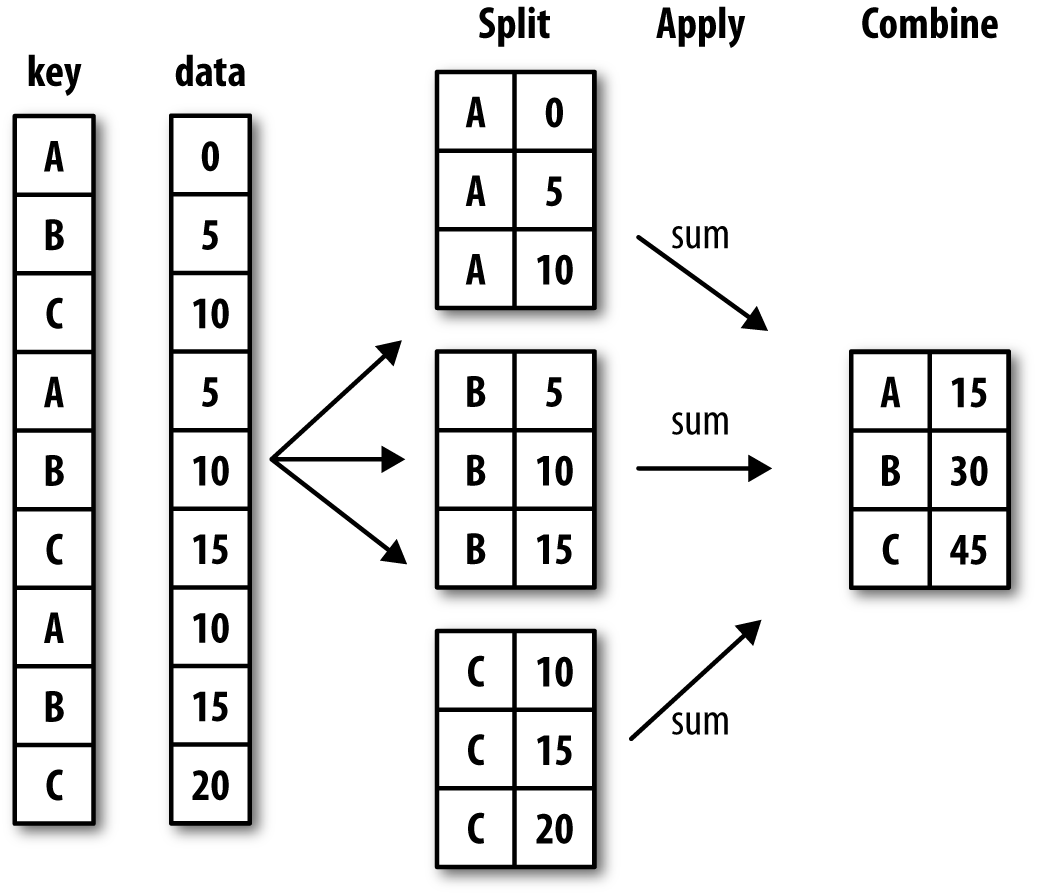

**Figure 10.2: Illustration of a group aggregation**    

Returning to the tipping dataset from before, suppose you wanted to select the top five `tip_pct` values by group. First, write a function that selects the rows with the largest values in a particular column:

In [ ]:
def top(df, n=5, column='tip_pct'):
    return df.sort_values(by=column)[-n:]
top(tips, n=6)

Now, if we group by `smoker`, say, and call `.apply()` with this function, we get the following:

In [ ]:
tips.groupby('smoker').apply(top)

What has happened here? The `.top()` function is called on each row group from the DataFrame, and then the results are glued together using `pandas.concat`, labeling the pieces with the group names. The result therefore has a hierarchical index whose inner level contains index values from the original DataFrame.

If you pass a function to `apply` that takes other arguments or keywords, you can pass these after the function:

In [ ]:
tips.groupby(['smoker', 'day']).apply(top, n=1, column='total_bill')

Beyond these basic usage mechanics, getting the most out of `apply` may require some creativity. What occurs inside the function passed is up to you; it must either return a pandas object or a scalar value. The rest of this chapter will mainly consist of examples showing you how to solve various problems using `groupby`.

For example, you may recall that I earlier called `.describe()` on a GroupBy object:

In [ ]:
result = tips.groupby('smoker')['tip_pct'].describe()
result
result.unstack('smoker')

Inside GroupBy, when you invoke a method like `.describe()`, it is actually just a shortcut for:

```
f = lambda x: x.describe()
grouped.apply(f)
```



---



### Suppressing the Group Keys

In the preceding examples, you see that the resulting object has a hierarchical index formed from the group keys along with the indexes of each piece of the original object. You can disable this by passing `group_keys=False` to `groupby`:

In [ ]:
tips.groupby('smoker', group_keys=False).apply(top)



---



### Quantile and Bucket Analysis

As you may recall from Data Wrangling: Join, Combine, [and Reshape], pandas has some tools, in particular `cut` and `qcut`, for slicing data up into buckets with bins of your choosing or by sample quantiles. Combining these functions with `groupby` makes it convenient to perform bucket or quantile analysis on a dataset. Consider a simple random dataset and an equal-length bucket categorization using `cut`:

In [ ]:
frame = pd.DataFrame({'data1': np.random.randn(1000),
                      'data2': np.random.randn(1000)})
quartiles = pd.cut(frame.data1, 4)
quartiles[:10]

The `Categorical` object returned by `cut` can be passed directly to `groupby`. So we could compute a set of group statistics for the quartiles like so:

In [ ]:
def get_stats(group):
    return {'min': group.min(), 'max': group.max(),
            'count': group.count(), 'mean': group.mean()}
grouped = frame.data2.groupby(quartiles)
grouped.apply(get_stats).unstack()

These were equal-length buckets; to compute equal-size buckets based on sample quantiles, use `qcut`. I’ll pass `labels=False` to just get quantile numbers:

In [ ]:
# Return quantile numbers
grouping = pd.qcut(frame.data1, 10, labels=False)
grouped = frame.data2.groupby(grouping)
grouped.apply(get_stats).unstack()



---



### Example: Filling Missing Values with Group-Specific       Values

When cleaning up missing data, in some cases you will replace data observations using `.dropna()`, but in others you may want to fill in the null (NA) values using a fixed value or some value derived from the data. `.fillna()` is the right tool to use; for example, here I fill in the null values with the mean:

In [ ]:
s = pd.Series(np.random.randn(6))
s[::2] = np.nan
s
s.fillna(s.mean())

Suppose you need the fill value to vary by group. One way to do this is to group the data and use `apply` with a function that calls `.fillna()` on each data chunk. Here is some sample data on US states divided into eastern and western regions:

In [ ]:
states = ['Ohio', 'New York', 'Vermont', 'Florida',
          'Oregon', 'Nevada', 'California', 'Idaho']
group_key = ['East'] * 4 + ['West'] * 4
data = pd.Series(np.random.randn(8), index=states)
data

Note that the syntax `['East'] * 4` produces a list containing four copies of the elements in `['East']`. Adding lists together concatenates them.

Let's set some values in the data to be missing:

In [ ]:
data[['Vermont', 'Nevada', 'Idaho']] = np.nan
data
data.groupby(group_key).mean()

We can fill the NA values using the group means like so:

In [ ]:
fill_mean = lambda g: g.fillna(g.mean())
data.groupby(group_key).apply(fill_mean)

In another case, you might have predefined fill values in your code that vary by group. Since the groups have a `name` attribute set internally, we can use that:

In [ ]:
fill_values = {'East': 0.5, 'West': -1}
fill_func = lambda g: g.fillna(fill_values[g.name])
data.groupby(group_key).apply(fill_func)



---



### Example: Random Sampling and Permutation

Suppose you wanted to draw a random sample (with or without replacement) from a large dataset for Monte Carlo simulation purposes or some other application. There are a number of ways to perform the “draws”; here we use the `.sample()` method for Series.

To demonstrate, here’s a way to construct a deck of English-style playing cards:

In [ ]:
# Hearts, Spades, Clubs, Diamonds
suits = ['H', 'S', 'C', 'D']
card_val = (list(range(1, 11)) + [10] * 3) * 4
base_names = ['A'] + list(range(2, 11)) + ['J', 'K', 'Q']
cards = []
for suit in ['H', 'S', 'C', 'D']:
    cards.extend(str(num) + suit for num in base_names)

deck = pd.Series(card_val, index=cards)

So now we have a Series of length 52 whose index contains card names and values are the ones used in Blackjack and other games (to keep things simple, I let the ace 'A' be 1):

In [ ]:
deck[:13]

Now, based on what I said before, drawing a hand of five cards from the deck could be written as:

In [ ]:
def draw(deck, n=5):
    return deck.sample(n)
draw(deck)

Suppose you wanted two random cards from each suit. Because the suit is the last character of each card name, we can `group` based on this and use `apply`:

In [ ]:
get_suit = lambda card: card[-1] # last letter is suit
deck.groupby(get_suit).apply(draw, n=2)

Alternatively, we could write:

In [ ]:
deck.groupby(get_suit, group_keys=False).apply(draw, n=2)



---



### Example: Group Weighted Average and Correlation

Under the split-apply-combine paradigm of `groupby`, operations between columns in a DataFrame or two Series, such as a group weighted average, are possible. As an example, take this dataset containing group keys, values, and some weights:

In [ ]:
df = pd.DataFrame({'category': ['a', 'a', 'a', 'a',
                                'b', 'b', 'b', 'b'],
                   'data': np.random.randn(8),
                   'weights': np.random.rand(8)})
df

The group weighted average by `category` would then be:

In [ ]:
grouped = df.groupby('category')
get_wavg = lambda g: np.average(g['data'], weights=g['weights'])
grouped.apply(get_wavg)



---



**Housekeeping: access the `stock_px_2.csv` file**    

Run the following !curl statement or upload the Wes McKinney example `stock_px_2.csv` to the current working directory for the code in this section to read. A copy of the [stock_px_2.csv](https://drive.google.com/file/d/1gDidm5bJsCv9ls7rk5yNzFfc5Yu5uR1K/view?usp=sharing) file is available from Professor Patrick's Google Drive [here](https://drive.google.com/file/d/1gDidm5bJsCv9ls7rk5yNzFfc5Yu5uR1K/view?usp=sharing).

In [ ]:
!curl https://raw.githubusercontent.com/wesm/pydata-book/2nd-edition/examples/stock_px_2.csv -o "stock_px_2.csv"



---



As another example, consider a financial dataset originally obtained from **Yahoo! Finance** containing end-of-day prices for a few stocks and the **S&P 500** index (the `SPX` symbol):

In [ ]:
# original WESM statement commented out due to directory name
# close_px = pd.read_csv('examples/stock_px_2.csv', parse_dates=True,
#                        index_col=0)
# replaced with the following statement to read from the current working directory
close_px = pd.read_csv('stock_px_2.csv', parse_dates=True,
                       index_col=0)
close_px.info()
close_px[-4:]

One task of interest might be to compute a DataFrame consisting of the yearly correlations of daily returns (computed from percent changes) with `SPX`. As one way to do this, we first create a function that computes the pairwise correlation of each column with the `'SPX'` column:

In [ ]:
spx_corr = lambda x: x.corrwith(x['SPX'])

Next, we compute percent change on `close_px` using `pct_change`:

In [ ]:
rets = close_px.pct_change().dropna()

Lastly, we group these percent changes by `year`, which can be extracted from each row label with a one-line function that returns the `year` attribute of each `atetime` label:

In [ ]:
get_year = lambda x: x.year
by_year = rets.groupby(get_year)
by_year.apply(spx_corr)

You could also compute inter-column correlations. Here we compute the annual correlation between Apple and Microsoft:

In [ ]:
by_year.apply(lambda g: g['AAPL'].corr(g['MSFT']))



---



### Example: Group-Wise Linear Regression

In the same theme as the previous example, you can use `groupby` to perform more complex group-wise statistical analysis, as long as the function returns a pandas object or scalar value. For example, I can define the following `regress` function (using the `statsmodels` econometrics library), which executes an ordinary least squares (OLS) regression on each chunk of data:

In [ ]:
import statsmodels.api as sm
def regress(data, yvar, xvars):
    Y = data[yvar]
    X = data[xvars]
    X['intercept'] = 1.
    result = sm.OLS(Y, X).fit()
    return result.params

Now, to run a yearly linear regression of `AAPL` on `SPX` returns, execute:

In [ ]:
by_year.apply(regress, 'AAPL', ['SPX'])



---



##10.4 Pivot Tables and Cross-Tabulation

A *pivot table* is a data summarization tool frequently found in spreadsheet programs and other data analysis software. It aggregates a table of data by one or more keys, arranging the data in a rectangle with some of the group keys along the rows and some along the columns. Pivot tables in Python with pandas are made possible through the `groupby` facility described in this chapter combined with reshape operations utilizing hierarchical indexing. DataFrame has a `pivot_table` method, and there is also a top-level `pandas.pivot_table` function. In addition to providing a convenience interface to `groupby`, `pivot_table` can add partial totals, also known as *margins*.

Returning to the tipping dataset, suppose you wanted to compute a table of group means (the default `pivot_table` aggregation type) arranged by `day` and `smoker` on the rows:

In [ ]:
tips.pivot_table(index=['day', 'smoker'])

This could have been produced with `groupby` directly. Now, suppose we want to take the average of only `tip_pct` and `size`, and additionally group by `time`. I’ll put `smoker` in the table columns and day in the rows:

In [ ]:
tips.pivot_table(['tip_pct', 'size'], index=['time', 'day'],
                 columns='smoker')

We could augment this table to include partial totals by passing `margins=True`. This has the effect of adding `All` row and column labels, with corresponding values being the group statistics for all the data within a single tier:

In [ ]:
tips.pivot_table(['tip_pct', 'size'], index=['time', 'day'],
                 columns='smoker', margins=True)

Here, the `All` values are means without taking into account smoker versus non-smoker (the `All` columns) or any of the two levels of grouping on the rows (the `All` row).

In [ ]:
tips.pivot_table('tip_pct', index=['time', 'smoker'], columns='day',
                 aggfunc=len, margins=True)

If some combinations are empty (or otherwise `NA`), you may wish to pass a `fill_value`:

In [ ]:
tips.pivot_table('tip_pct', index=['time', 'size', 'smoker'],
                 columns='day', aggfunc='mean', fill_value=0)

See **Table 10.2** for a summary of `pivot_table` options.

**Table 10.2: pivot_table options**    


**Function name	  -    Description**    

* **values** - 	Column name or names to aggregate; by default aggregates all numeric columns    
* **index** - 	Column names or other group keys to group on the rows of the resulting pivot table    
* **columns** - 	Column names or other group keys to group on the columns of the resulting pivot table    
* **aggfunc** - 	Aggregation function or list of functions ('mean' by default); can be any function valid in a groupby context    
* **fill_value** - 	Replace missing values in result table     
* **dropna** - 	If True, do not include columns whose entries are all NA     
* **margins** - 	Add row/column subtotals and grand total (False by default)    
* **margins_name** - 	Name to use for the margin row/column labels when passing `margins=True`, defaults to 'All'     
* **observed** - 	With Categorical group keys, if True only show the observed category values in the keys rather than all categories.    





---



### Cross-Tabulations: Crosstab

A cross-tabulation (or crosstab for short) is a special case of a pivot table that computes group frequencies. Here is an example:

In [ ]:
from io import StringIO
data = """\
Sample  Nationality  Handedness
1   USA  Right-handed
2   Japan    Left-handed
3   USA  Right-handed
4   Japan    Right-handed
5   Japan    Left-handed
6   Japan    Right-handed
7   USA  Right-handed
8   USA  Left-handed
9   Japan    Right-handed
10  USA  Right-handed"""
data = pd.read_table(StringIO(data), sep='\s+')

In [ ]:
data

As part of some survey analysis, we might want to summarize this data by nationality and handedness. You could use `pivot_table` to do this, but the `pandas.crosstab` function can be more convenient:

In [ ]:
pd.crosstab(data.Nationality, data.Handedness, margins=True)

The first two arguments to `crosstab` can each either be an array or Series or a list of arrays. As in the tips data:

In [ ]:
pd.crosstab([tips.time, tips.day], tips.smoker, margins=True)

In [ ]:
pd.options.display.max_rows = PREVIOUS_MAX_ROWS



---



##10.5 Conclusion

Mastering pandas's data grouping tools can help both with data cleaning as well as modeling or statistical analysis work. In [Data Analysis Examples](https://wesmckinney.com/book/data-aggregation.html#data-analysis-examples) we will look at several more example use cases for `groupby` on real data.

In the next chapter, we turn our attention to time series data.   




---

